In [1]:
import torch

torch.manual_seed(0)

import gpytorch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

plt.style.use("bmh")
plt.rcParams["image.cmap"] = "Blues_r"

from tqdm.notebook import tqdm

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

dataset1 = datasets.MNIST("../data", train=True, download=True, transform=transform)
dataset2 = datasets.MNIST("../data", train=False, download=True, transform=transform)

train_x = dataset1.data[:1000, ...].view(1000, -1).to(torch.float)
train_y = dataset1.targets[:1000]

test_x = dataset2.data[:500, ...].view(500, -1).to(torch.float)
test_y = dataset2.targets[:500]

In [3]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
# declare the GP
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)

# train the hyperparameter
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
lengthscales = []
outputscales = []
for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())
    lengthscales.append(model.covar_module.base_kernel.lengthscale.item())
    outputscales.append(model.covar_module.outputscale.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [5]:
with torch.no_grad():
    mean_preds = model(test_x).mean

print(f"mean absolute error: {torch.mean(torch.abs(mean_preds - test_y))}")

mean absolute error: 2.7021291255950928


In [6]:
data_dim = train_x.size(-1)


class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self, datea_dim):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module("linear1", torch.nn.Linear(data_dim, 1000))
        self.add_module("relu1", torch.nn.ReLU())
        self.add_module("linear2", torch.nn.Linear(1000, 500))
        self.add_module("relu2", torch.nn.ReLU())
        self.add_module("linear3", torch.nn.Linear(500, 50))
        self.add_module("relu3", torch.nn.ReLU())
        self.add_module("linear4", torch.nn.Linear(50, 2))


feature_extractor = LargeFeatureExtractor(data_dim)

In [7]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
            num_dims=2,
            grid_size=100,
        )
        self.feature_extractor = feature_extractor

        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1.0, 1.0)

    def forward(self, x):
        projected_x = self.feature_extractor(x)
        projected_x = self.scale_to_bounds(projected_x)

        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [8]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

In [9]:
optimizer = torch.optim.Adam(
    [
        {"params": model.feature_extractor.parameters()},
        {"params": model.covar_module.parameters()},
        {"params": model.mean_module.parameters()},
        {"params": model.likelihood.parameters()},
    ],
    lr=0.01,
)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()
    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

/Users/alextanhongpin/Library/Caches/pypoetry/virtualenvs/python-bayesian-optimization-in-action-aU6qUxK9-py3.12/lib/python3.12/site-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/Users/alextanhongpin/Library/Caches/pypoetry/virtualenvs/python-bayesian-optimization-in-action-aU6qUxK9-py3.12/lib/python3.12/site-packages/linear_operator/utils/sparse.py:66: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:646.)
  res = cls(index_tensor, value_tensor, interp_size)


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [11]:
with torch.no_grad():
    extracted_features = model.feature_extractor(train_x)
    extracted_features = model.scale_to_bounds(extracted_features)

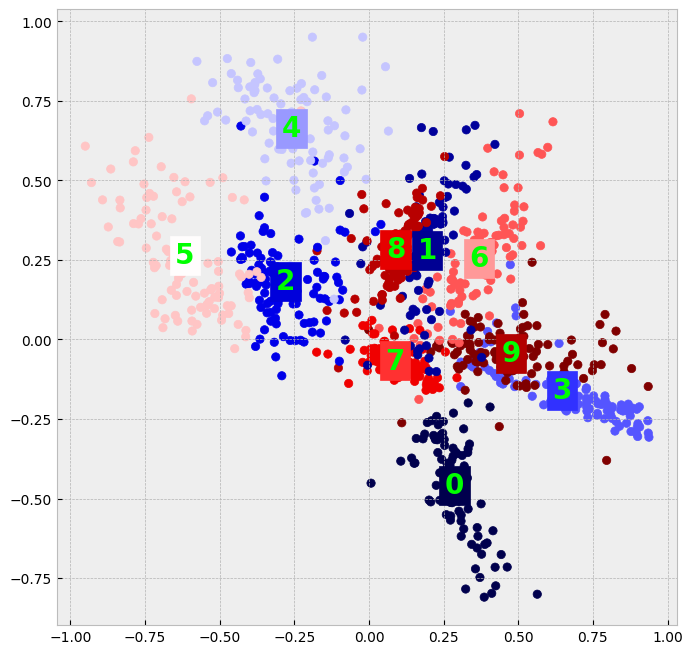

In [12]:
random_map = {
    0: 0,
    1: 3,
    2: 9,
    3: 6,
    4: 7,
    5: 1,
    6: 8,
    7: 2,
    8: 4,
    9: 5,
}

plt.figure(figsize=(8, 8))

for label in range(10):
    mask = train_y == label

    plt.scatter(
        extracted_features[mask, 0],
        extracted_features[mask, 1],
        c=torch.ones_like(train_y[mask]) * random_map[label],
        vmin=0,
        vmax=9,
        label=random_map[label],
        cmap="seismic",
    )

    plt.annotate(
        random_map[label],
        (extracted_features[mask, 0].mean(), extracted_features[mask, 1].mean()),
        horizontalalignment="center",
        verticalalignment="center",
        size=20,
        weight="bold",
        color="lime",
        backgroundcolor=plt.cm.seismic(random_map[label] * 0.1),
    )

# plt.legend()
plt.show()

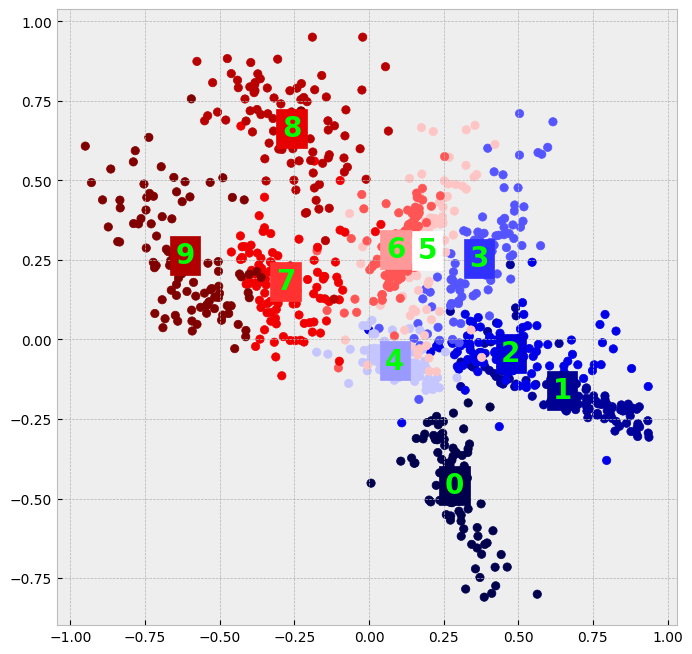

In [13]:
plt.figure(figsize=(8, 8))

for label in range(10):
    mask = train_y == label

    plt.scatter(
        extracted_features[mask, 0],
        extracted_features[mask, 1],
        c=train_y[mask],
        vmin=0,
        vmax=9,
        label=label,
        cmap="seismic",
    )

    plt.annotate(
        label,
        (extracted_features[mask, 0].mean(), extracted_features[mask, 1].mean()),
        horizontalalignment="center",
        verticalalignment="center",
        size=20,
        weight="bold",
        color="lime",
        backgroundcolor=plt.cm.seismic(label * 0.1),
    )

# plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    mean_preds = model(test_x).mean

print(f"mean absolute error: {torch.mean(torch.abs(mean_preds - test_y))}")